# Methods in Bioinformatics, Homework 1 for Computer Science Students, 2024/25

## Introduction
In this homework, your task is to implement and evaluate algorithms for comparing two genomes based on their sets of $k$-mers. Tasks 1 and 2 ask you to implement several techniques covered in [Tutorial 5](https://fmfi-compbio.github.io/mbi/notes/ci-aln2.html) for CS students. The remaining tasks ask you to observe the behavior of these techniques in terms of accuracy, running time and memory on real and simulated data.

If you want to read more about the concepts from this homework, check these sources
* Jaccard index: https://en.wikipedia.org/wiki/Jaccard_index, https://www.statology.org/jaccard-similarity/
* Minimizers: https://homolog.us/blogs/bioinfo/2017/10/25/intro-minimizer/</li>

## Use of AI and other sources

* As per [course rules](https://fmfi-compbio.github.io/mbi/Rules.html#academic-integrity) you are allowed to discuss the homework with your classmates in general terms, but all your code and texts should be **your own work**. In the bonus version of task 2.1 you are allowed to research the algorithm in existing sources as explained below.  In **tasks 1 and 2 do not use AI to generate your code, switch off AI assistant** in your working environment (e.g. in Google Colab, in the main menu Tools -> Settings -> AI assistence -> Hide generative AI features). In tasks 3-6 you may use AI to help with setting up appropriate plots, but if you do, acknowledge such help in comments in your code and make sure that the plots correctly display the desired quantities. Your discussion should be written in your own words, do not generate it using AI.   


## Technical requirements and recommendations

* This notebook contains the task description, some useful helper functions, as well as some code to test your implementation in Tasks 1 and 2. Please do not modify the provided code and write your code in the indicated space. Run all cells, included those with pur code.
* In your code for tasks 1-2, use only libraries already imported in the provided code and functions provided by us, such as `canonical` and `shash`.
* In tasks 3-6 you may use also other libraries. Measure all required quantities in the notebook and either visualize them directly there, or if you prefer, you can create final visualizations in another system.
* Your notebook should be executable on Google Colab. If you use any libraries not available on Colab by default, install them using `pip install` commands included in the notebook (section Libraries for tasks 3-6). If you use a different environment to develop your code, test it in Colab before submitting.
* To avoid running out of memory, we recommend deleting variables that are no longer needed using `del` and occasionally calling `gc.collect()` to run garbage collection and free unused memory.
* Some computations may take a long time to run. Leave sufficient time for finish the assignment. If the computation takes too long, you may try to improve your implementation.


## Submitting

* Submit the notebook with your code as an ipynb file. All cells should be executed with output shown.
* Tasks 3-6 ask you make some measurements, summarize them in tables or plots and discuss your results. You can include all these visualizations and discussion directly in this notebook, or if you prefer, you can submit them as a separate pdf (if you make plots in a different software).
* Text parts of the homework can be written in English or Slovak. The individual plots and tables should be properly annotated (axis labels, legends and titles or captions).

## Module imports (do not modify)

Use only modules listed below in parts 1 and 2. The code below uses pip command to install the Biopython library. If you have this library installed, you can comment out the line starting `!pip`.

In [1]:
# imports
import io
import os
import re
import gc
import sys
import random
import hashlib
import time
# numba library can precompile and speed up your code
from numba import njit

# libraries potentially useful in parts 1 and 2
import heapq
import itertools
from collections import deque
from collections.abc import Callable

# biopython library is used for parsing the input file
# The line below instals it. You may comment this line
# if it is already installed in your environment.
!pip install biopython
from Bio import SeqIO

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 15.8 MB/s eta 0:00:00


## Function definitions (do not modify)

We provide the following functions for you to use in your code:
* Function `canonical` returns the *canonical* version of an input $k$-mer defined as follows. For a $k$-mer $w$, let $w’$ be its reverse complement (obtained by reversing the string and exchanging complementary bases A<->T, C<->G). The canonical $k$-mer $w$ is then the smaller of $w$ and $w’$ in the lexicographic (alphabetical) order. For example, 4-mer CACT has reverse complement AGTG, which happens to be lexicographically smaller than CACT, and thus it is its canonical version.
* Function `full_kmer_set` gets a string consisting of letters A,C,G,T representing a single genome and integer `k` and returns a Python set of all canonical $k$-mers of the input string. Canonical $k$-mers help us to represent both strands of the DNA molecule (the genome and its reverse complement will produce the same set of canonical $k$-mers).
* Function `shash` computes a hash value for a $k$-mer. Use it for minimizer computations.
* Function `debug_hash` is a simple hash function which simply encodes a k-mer as a number. Use to debug your minimizer code.

In [2]:
@njit
def c(x: str) -> str:
  """Returns complement of a single DNA base"""
  if x == 'A':
    return 'T'
  elif x == 'T':
    return 'A'
  elif x == 'C':
    return 'G'
  elif x == 'G':
    return 'C'
  else:
    return ""


@njit
def _reverse_complement(seq: str) -> str:
  """Returns reverse complement (opposite strand) of a DNA sequence"""
  return "".join([c(seq[i]) for i in range(len(seq)-1, -1, -1)])


@njit
def canonical(kmer: str) -> str:
  """Returns a canonical k-mer for the input k-mer. """
  comp_kmer = _reverse_complement(kmer)
  if kmer <= comp_kmer:
    return kmer
  else:
    return comp_kmer


@njit
def full_kmer_set(sequence: str, k: int) -> set[str]:
  """Function gets a string consisting of letters A,C,G,T representing a single genome
  and integer k and returns a Python set of all canonical k-mers of the input string."""
  result = set()
  for start in range(len(sequence) - k + 1):
    result.add(canonical(sequence[start:start+k]))
  return result


def shash(seq: str) -> int:
  """A hash function to be used for hashing k-mers in minimizers and MinHash"""
  hasher = hashlib.blake2b(salt=b'')
  hasher.update(seq.encode(encoding='utf-8'))
  d = hasher.digest()
  result = int.from_bytes(d[:5], byteorder='little')
  return result

def debug_hash(seq: str) -> int:
  """A simple hash function which encodes DNA as a base-4 number
  with A being digit 0, C 1, G 2, T 3. This is to be used for debugging minimizers"""
  base2num = {'A':0, 'C':1, 'G':2, 'T':3}
  result = 0;
  for base in seq:
    result = result*4 + base2num[base]
  return result

# testing
print(f"{[x + '->' + c(x) for x in 'ACGT']}")
print(f"{_reverse_complement('AGTG')=}")
print(f"{_reverse_complement('CACT')=}")
print(f"{canonical('AGTG')=}")
print(f"{canonical('CACT')=}")
print(f"{list(full_kmer_set('CCAAGGTCCATC', k=3))=}")
print(f"{shash('A' * 13)=}, {shash('ACTACTACTACTG')=} {shash('T'*12 + 'A')=}")
print(f"{debug_hash('AAA')=}, {debug_hash('AAG')=}, {debug_hash('CAA')=}, {debug_hash('TTT')=}")

['A->T', 'C->G', 'G->C', 'T->A']
_reverse_complement('AGTG')='CACT'
_reverse_complement('CACT')='AGTG'
canonical('AGTG')='AGTG'
canonical('CACT')='AGTG'
list(full_kmer_set('CCAAGGTCCATC', k=3))=['AGG', 'GAC', 'CCA', 'ACC', 'CAA', 'ATG', 'ATC', 'GGA', 'AAG']
shash('A' * 13)=281618300821, shash('ACTACTACTACTG')=687357743147 shash('T'*12 + 'A')=912656793854
debug_hash('AAA')=0, debug_hash('AAG')=2, debug_hash('CAA')=16, debug_hash('TTT')=63


## Downloading genomes (do not modify)

This part downloads some real genomes as follows.

* It uses `read_fasta` function to download a file from URL `http://compbio.fmph.uniba.sk/vyuka/mbi-data/du1/bacteria.fasta`. This file contains several bacterial genomes in the FASTA format. The function returns two lists stored in variables `real_genomes` and `real_genome_descriptions`.
  * The first variable is a list of strings consisting of letters A,C,G,T. (Some of these genomes contain unknown bases denoted as N; these are for simplicity omitted.)
  * The second variable is a list of strings of the same length containing a text description of the sequence and its identifier from the RefSeq database.
* We will refer to these genomes by numbers $0,1,\dots$ based on their index in the two lists.
* When you run this cell first time, the sequences will be downloaded from the internet and saved to `bacteria.fasta` file. Subsequently, this file will be read instead.


In [3]:
def read_fasta(url=None, filename=None):
  """Function reads sequences in a FASTA format and returns them as a list of strings consisting of letters A,C,G,T.
  It also returns a list of descriptions of these sequences. If filename is given and it exists,
  sequences are read from the file. Otherwise they are read from the URL and written to the file."""

  # open file or url
  handle = None
  output_handle = None
  if filename is not None and os.path.isfile(filename) \
  and os.path.getsize(filename) > 0:
    handle = open(filename, 'r')
  elif url is not None:
    from urllib.request import urlopen
    handle = io.TextIOWrapper(urlopen(url), encoding='utf-8')
    if filename is not None:
      output_handle = open(filename, "w")

  real_genomes, real_genome_descriptions = [], []
  for gnum, genome in enumerate(SeqIO.parse(handle, "fasta")):
    if output_handle is not None:
      SeqIO.write(genome, output_handle, "fasta")
    sequence = str(genome.seq).replace('N', '')
    if not re.match(r'\A[ACGT]+\Z', sequence):
      raise ValueError(f"Bad genome characters in the input file")
    description = genome.description
    real_genomes.append(sequence)
    real_genome_descriptions.append(description)
    print(f"Parsed genome #{gnum}: {description[:70]}...", file=sys.stderr)

  if output_handle is not None:
    output_handle.close()
  handle.close()

  return real_genomes, real_genome_descriptions


start = time.time()
url = "http://compbio.fmph.uniba.sk/vyuka/mbi-data/du1/bacteria.fasta"
real_genomes, real_genome_descriptions = read_fasta(url=url, filename="bacteria.fasta")
if len(real_genomes) != 9:
  raise Exception("Some problem with reading sequences, perhaps delete bacteria.fasta file")
gc.collect()
end = time.time()
print(f"Downloading genomes took {end-start} seconds")

Parsed genome #0: NC_000913.3 Escherichia coli str. K-12 substr. MG1655, complete genome...
Parsed genome #1: NZ_CP031922.1 Escherichia coli O26:H11 strain FWSEC0001 chromosome, co...
Parsed genome #2: NZ_CP083638.1 Escherichia fergusonii strain FDAARGOS_1499 chromosome, ...
Parsed genome #3: NC_007795.1 Staphylococcus aureus subsp. aureus NCTC 8325 chromosome, ...
Parsed genome #4: NC_016845.1 Klebsiella pneumoniae subsp. pneumoniae HS11286 chromosome...
Parsed genome #5: NC_002695.2 Escherichia coli O157:H7 str. Sakai DNA, complete genome...
Parsed genome #6: NZ_CP009756.1 Enterobacter cloacae strain GGT036 chromosome, complete ...
Parsed genome #7: NZ_AP019632.1 Enterobacter asburiae strain 1808-013 chromosome, comple...
Parsed genome #8: NZ_AP022508.1 Enterobacter bugandensis strain STN0717-56 chromosome, c...


## Creating mutated genomes (do not modify)

This part will create some artificially mutated versions of genome 0 downloaded in the previous section
* Function `mutate` gets a string consisting of letters A,C,G,T representing a single genome and a mutation probability $p$ (a real number between 0 and 1). For each base
of the input string it mutate it with probability $p$ and leave it as it was with probability $1-p$. If the base is mutated, it is replaced by a randomly chosen base from the remaining three.
* We create artificially mutated versions of genome 0 with mutation probabilities $p$=0.01, 0.05, 0.1, 0.2, 0.3, 0.4. As a result you have 6 new genomes stored in list `mutated_genomes`. The corresponding values of $p$ are in list `mutation_probabilities`.
* To make the results reproducible, we set random seed to 47. Do not change this value.

In [4]:
@njit
def mutate(sequence: str, p: float) -> str:
  """Function gets a string consisting of letters A,C,G,T representing a single genome and a mutation probability p (a real number between 0 and 1).
  For each base of the input string it will decide with probability p to mutate it or 1-p to leave it as it was.
  If the base is mutated, it is replaced by a randomly chosen base from the remaining three."""
  others = {x: "ACGT".replace(x, "") for x in "ACGT"}
  result = "".join([x if random.random() > p else others[x][random.randint(0, 2)] for x in sequence])
  return result

# testing function
print(f"{[mutate('AAAACCCCGGGGTTTT', p=0.25) for _ in range(5)]=}")

# creating needed variables
mutation_probabilities = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4]
random.seed(47)
mutated_genomes = [mutate(real_genomes[0], p) for p in mutation_probabilities]
gc.collect()

[mutate('AAAACCCCGGGGTTTT', p=0.25) for _ in range(5)]=['AAAAGCCCGGTGCTTT', 'AAAACCCAGGGGTGTT', 'AAAACCCCGGCGTTTT', 'ACAACCCCGGGACTAT', 'GTAACCCAGTGGTTTA']


38599

## Task 1: Jaccard similarity

In this task we write functions for comparing two DNA sequences based on the Jaccard similarity of their sets of canonical $k$-mers. More similar sequence typically have a higher Jaccard similarity (more on this in Task 3).

### Task 1.1: Implement function `jaccard`

Implement function `jaccard` which gets two sets and computes their Jaccard similarity by considering the sizes of their intersection and union. You can assume that the union of the two sets is non-empty.

In [5]:
def jaccard(first_set: set[str], second_set: set[str]) -> float:
  """Function gets two sets and computes their Jaccard similarity."""
  return float(len(first_set&second_set)) / len(first_set|second_set)


### Task 1.2: Implement function `kmer_jaccard`

Implement function `kmer_jaccard` which gets one DNA sequence, a list of $n$ DNA sequences and a value of `k`, converts all sequences to k-mer sets using provided function `full_kmer_set` and computes a list of $n$ Jaccard similarities of the first sequence compared each of the sequences in the list. You can assume that all sequences have length at least $k$.

In [6]:
def kmer_jaccard(first_sequence: str, sequence_list: list[str], k: int) -> list[float]:
  set1 = full_kmer_set(first_sequence,k)
  ans = []
  for sequence in sequence_list:
    cur_set = full_kmer_set(sequence,k)
    ans.append(jaccard(set1,cur_set))
  return ans

### Task 1.3: Test your code on small tests

Run your function on small debuging inputs below and check if the answer is correct. Do not modify the tests, but you can add more of them.

In [7]:
setA = {'abc'}
setB = {'bb'}
setAB = {'abc','bb'}
setABC = {'abc', 'bb', 'cde'}
print(f"{jaccard(setA, setA)=} (should be {1.0})")
print(f"{jaccard(setA, setB)=} (should be {0.0})")
print(f"{jaccard(setA, setAB)=} (should be {1/2})")
print(f"{jaccard(setA, setABC)=} (should be {1/3})")
print(f"{jaccard(setAB, setA)=} (should be {1/2})")
print(f"{jaccard(setAB, setABC)=} (should be {2/3})")

seq1 = "AAACCC"
seq2 = "GGGTTT"  # reverse complement of seq1, identical set of canonical k-mers
seq3 = "AAAGTG"
seq4 = "ACAC"
print(f"{kmer_jaccard(seq1, [seq1, seq2, seq3, seq4], 3)=}")
print(f"  results should be {[1.0, 1.0, 1/7, 0.0]}")

jaccard(setA, setA)=1.0 (should be 1.0)
jaccard(setA, setB)=0.0 (should be 0.0)
jaccard(setA, setAB)=0.5 (should be 0.5)
jaccard(setA, setABC)=0.3333333333333333 (should be 0.3333333333333333)
jaccard(setAB, setA)=0.5 (should be 0.5)
jaccard(setAB, setABC)=0.6666666666666666 (should be 0.6666666666666666)
kmer_jaccard(seq1, [seq1, seq2, seq3, seq4], 3)=[1.0, 1.0, 0.14285714285714285, 0.0]
  results should be [1.0, 1.0, 0.14285714285714285, 0.0]


## Task 2: Minimizers

In this task we write an alternative way of comparing two sequences using Jaccard similarity of their sets of minimizers instead of all $k$-mers. The set of minimizers is potentially smaller, thus saving time and memory if many sets are compared to each other.


### Task 2.1 Implement function `minimizer_set`

Implement function `minimizer_set` which gets a string consisting of letters A,C,G,T, two parameters `k` and `s` and hash function `h`. For each sliding window of `s` consecutive `k`-mers, it computes the canonical versions of these $k$-mers, applies function `h` on each canonical $k$-mer, chooses the canonical $k$-mer with the smallest hash value and stores this $k$-mer in the set. You can assume that the length of the sequence is at least $k-s+1$.

For example let $k=2$, $s=3$ and we use the `debug_hash` to find minimizers for sequence 'AAGGG'.  We first take first three $2$-mers 'AA', 'AG', 'GG'. Their canonical versions are 'AA', 'AG', 'CC'. Their hash values are  0, 2, and 5. The minimum is 0 corresponding to canonical $k$-mer 'AA'. The next sliding window has canonical $k$-mers 'AG', 'CC', 'CC' with hash values 2, 5, 5. Now canonical $k$-mer AG is the minimizer. The resulting set will be therefore {'AA', 'AG'}.

The running time of your function on a sequence of length $n$ should be at most $O(n(k+s))$ assuming that a hash function and canonical version of one $k$-mer can be computed in $O(k)$ time. For bonus points you can try to implement a more efficient version running in $O(n(k+\log s))$ time or even $O(nk)$ time. You can try to find the $O(nk)$ time algorithm by searching in literature / on the internet, if you wish, but cite your source. You should understand the algorithm, implement it in your own code and explain it in your own words below.

In [8]:
def minimizer_set(sequence: str, k: int, s: int,
                  h: Callable[[str], int]) -> set[str]:
  """Function gets a string consisting of letters A,C,G,T,
  two parameters k and s and hash function h
  and returns a Python set of all minimizers of the string. """
  if len(sequence) < k + s - 1 or k < 1 or s < 1:
    raise ValueError("Sequence must have length at least k + s -1 for k>=1, s>=1.")

  ans = set()
  cur_string = sequence[:k]
  cur = [cur_string]
  for i in range(k,len(sequence)):
    cur_string+=sequence[i]
    cur_string=cur_string[1:]
    cur.append(canonical(cur_string))
    if(len(cur)>s):
      cur.pop(0)
    if(len(cur)==s):
      mn = 1e9
      toAdd = None
      for seq in cur:
        if h(seq)<mn:
          mn = h(seq)
          toAdd = seq
      ans.add(toAdd)




  return ans

### Task 2.2

Briefly explain the algorithm used by your function above and what is its running time in terms of $n$, $k$ and $s$. Write your explanation directly here or to the accompanying pdf document.

We go through sequence and store the substring with length $k$ that ends in current index. For all $k$-mers we went through we store at most $s$ consecutive ones.
Then if we already have $s$ $k$-mers we count minimizer for them.

This solution have complexity $O(n*(s+k))$ (Main loop with $n$ iterations, Finding canonical string by $O(k)$ and linear search in list with maximal size $s$).

This complexi
ty could be easily improved to $O(n*log(s))$ by usage another libs. Firsty, we could use SortedList and store pairs (value,seq) in cur. Sorting will be done by value, finding minimizer is $O(1)$ (it's always first element), insert and erase is $O(log (s))$.
Then we can use another structure for cur_string where deleting first element is $O(1)$ (for example Queue), then final complexity will be $O(n)*((O(log(s))+O(1))+O(k))=O(n*(log(s)+k))$.

### Task 2.3: Implement function `minimizer_jaccard`

Implement function `minimizer_jaccard` which works similarly to `kmer_jaccard` in task 1.2, but runs `minimizer_set` instead of `full_kmer_set`. For this purpose it also gets value `s` and hash function `h` as parameters.

In [9]:
def minimizer_jaccard(first_sequence: str, sequence_list: list[str],
                      k: int, s: int, h: Callable[[str], int]) -> list[float]:
  set1 = minimizer_set(first_sequence,k,s,h)
  ans = []
  for sequence in sequence_list:
    cur_set = minimizer_set(sequence,k,s,h)
    ans.append(jaccard(set1,cur_set))
  return ans

### Task 2.4: Test your code on small tests

Run your function on small debuging lists below and check if the answer is correct. Do not modify the tests, but you can add more of them.

In [10]:
print(f"{minimizer_set('AAACGCAAA', 3, 3, debug_hash)=}")
print(f"Result should be {set(['AAA', 'AAC', 'ACG', 'CAA'])}")
print()
print(f"{minimizer_set('AAACGCAAAGGGGG', 2, 4, debug_hash)=}")
print(f"Result should be {set(['AA', 'AC', 'AG', 'CC'])}")
print("  note that canonical string of GG is CC")
print()

seq1 = "AAACCC"
seq2 = "GGGTTT"  # reverse complement of seq1, identical set of canonical k-mers
seq3 = "AAAGTG"
seq4 = "ACAC"
print(f"{minimizer_jaccard(seq1, [seq1, seq2, seq3, seq4], 2, 2, debug_hash)=}")
print(f"  results should be {[1.0, 1.0, 2/3, 1/3]}")

minimizer_set('AAACGCAAA', 3, 3, debug_hash)={'AAA', 'CAA', 'ACG', 'AAC'}
Result should be {'AAA', 'CAA', 'ACG', 'AAC'}

minimizer_set('AAACGCAAAGGGGG', 2, 4, debug_hash)={'AC', 'AA', 'AG', 'CC'}
Result should be {'AC', 'AA', 'AG', 'CC'}
  note that canonical string of GG is CC

minimizer_jaccard(seq1, [seq1, seq2, seq3, seq4], 2, 2, debug_hash)=[1.0, 1.0, 0.6666666666666666, 0.3333333333333333]
  results should be [1.0, 1.0, 0.6666666666666666, 0.3333333333333333]


## Libraries for tasks 3-6

The code below loads several libraries that are often used for data processing and visualization. Feel free to use them in parts 3-6. You can also import additional libraries if needed.

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# TODO: add more libraries if needed

## Task 3: Accuracy of *k*-mer Jaccard index

In this task we want to evaluate if Jaccard similarity on a full set of $k$-mers is a suitable measure of sequence similarity. To this end, we will use randomly mutated genomes for different values of mutation probability $p$. We will consider 1-$p$ as the true genome similarity (the percentage of bases that were conserved) and see if the Jaccard similarity is in some way related to this value.



### Task 3.1. Formula for $k$-mer conservation

Consider two sequences where the second one was created from the first by randomly mutation each base with probability $p$ and leaving it the same with probability $(1-p)$ (as in function `mutate` above). Let $f(p, k)$ be a probability that a $k$-mer at a particular fixed position in these genomes does not contain any mutations (all $k$ nucleotides were left the same).

Write a mathematical formula for $f(p, k)$ and explain it. You can write your formula directly here or to the accompanying pdf document.

We want to compute the probability that action with probability $p$ will be done $0$ out of $k$ times. We can do it by Binomial Probability Formula as $f(p,k)=(1-p)^k$


### Task 3.2 Compute and show tables

Compute a table containing values of $f(p,k)$ for  $p$ from `mutation_probabilities` list and values of $k$=9,13,17. Also compute Jaccard similarities
between real genome 0 and all 6 mutated genomes for values of the same list of values of $k$. Print both tables in some easy to read form.


In [22]:
def f(p,k):
  return (1-p)**k

values_k = set([9,13,17])

for p in mutation_probabilities:
  for k in values_k:
    print("p=",p,",k=",k,",f(p,k)=",f(p,k))

jaccard_sim = {}

print("JACCARD SIMILIARITY")
for k in values_k:
  jaccard_sim[k] = kmer_jaccard(real_genomes[0],mutated_genomes,k)
  print("k=",k, "Jaccard Similarity=",jaccard_sim[k])


p= 0.01 ,k= 9 ,f(p,k)= 0.9135172474836408
p= 0.01 ,k= 13 ,f(p,k)= 0.8775210229989678
p= 0.01 ,k= 17 ,f(p,k)= 0.8429431933839268
p= 0.05 ,k= 9 ,f(p,k)= 0.6302494097246091
p= 0.05 ,k= 13 ,f(p,k)= 0.5133420832795048
p= 0.05 ,k= 17 ,f(p,k)= 0.4181203352191771
p= 0.1 ,k= 9 ,f(p,k)= 0.3874204890000001
p= 0.1 ,k= 13 ,f(p,k)= 0.2541865828329001
p= 0.1 ,k= 17 ,f(p,k)= 0.16677181699666577
p= 0.2 ,k= 9 ,f(p,k)= 0.13421772800000006
p= 0.2 ,k= 13 ,f(p,k)= 0.054975581388800036
p= 0.2 ,k= 17 ,f(p,k)= 0.022517998136852502
p= 0.3 ,k= 9 ,f(p,k)= 0.04035360699999998
p= 0.3 ,k= 13 ,f(p,k)= 0.009688901040699992
p= 0.3 ,k= 17 ,f(p,k)= 0.0023263051398720674
p= 0.4 ,k= 9 ,f(p,k)= 0.010077695999999997
p= 0.4 ,k= 13 ,f(p,k)= 0.0013060694015999993
p= 0.4 ,k= 17 ,f(p,k)= 0.00016926659444735988
JACCARD SIMILIARITY
k= 9 Jaccard Similarity= [0.9946494139651829, 0.9907193992032116, 0.9904555546230669, 0.9904556274414062, 0.9904556274414062, 0.9904556274414062]
k= 13 Jaccard Similarity= [0.8029594528307986, 0.41355327

### Task 3.3 Plot(s) and discussion

Create plots showing how values in both tables from Task 3.2 change with $1-p$. For example you can create a line plot showing $1-p$ on the x axis (true genome similarity) and the Jaccard similarity (genome similarity estimate) on the y axis. Use one line for each value of $k$; the line connects values for mutated genomes for increasing value of $1-p$. Similarly you can plot values $f(p,k)$ instead od Jaccard. You can also add other plots to support your discussion.

Then propose a method how we could estimate $1-p$ from the Jaccard similarity for values of $k$ investigated here using the values you measured or some other calculation you can make. Are some values of $k$ unsuitable (or less suitable) for this purpose? Why is that?

f(p,k)
BLUE: k=9, ORANGE: k=13, GREEN: k=17


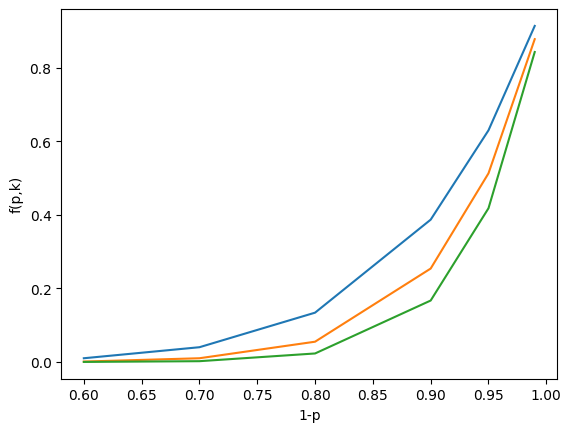

JACCARD SIMILARITY
BLUE: k=9, ORANGE: k=13, GREEN: k=17


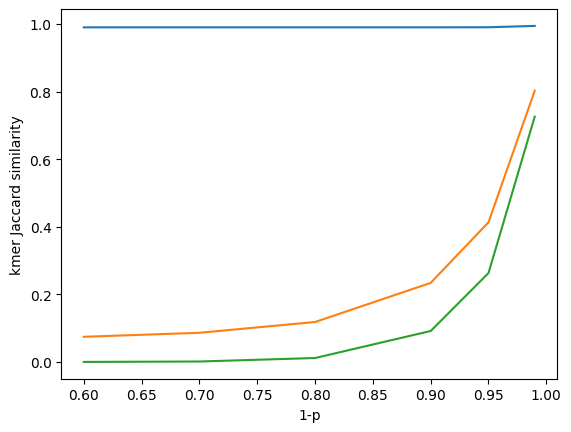

In [28]:
print("f(p,k)")
print("BLUE: k=9, ORANGE: k=13, GREEN: k=17")
for k in values_k:
  x = []
  y = []
  for p in mutation_probabilities:
      x.append(1-p)
      y.append(round(f(p,k),3))
  plt.plot(x,y,label=f'k={k}')
  plt.xlabel("1-p")
  plt.ylabel("f(p,k)")
plt.show()

print("JACCARD SIMILARITY")
print("BLUE: k=9, ORANGE: k=13, GREEN: k=17")

for k in values_k:
  x = []
  y = []
  for i in range(6):
      x.append(1-mutation_probabilities[i])
      y.append(jaccard_sim[k][i])
  plt.plot(x,y,label=f"k={k}")
  plt.xlabel("1-p")
  plt.ylabel("kmer Jaccard similarity")
plt.show()

Place your discussion here or together with your visualizations to the accompanying pdf document.

## Task 4: Jaccard index on real genomes

* Compare genome 0 to all real genomes using Jaccard similarity on a full set of $k$-mers for $k$=13. Print a table listing these similarities as well as genome descriptions.
* Discuss the results. Which other genomes are most similar to genome 0? Can you explain this by looking at their descriptions? Can you make some estimate of the percentage of mutated bases between these pairs of genomes based on your results in Task 3?

In [29]:
print("GENOME 0 DISCRIPTION: ",real_genome_descriptions[0])
genome_similarity = kmer_jaccard(real_genomes[0],real_genomes,13)
for i in range(1,len(real_genomes)):
  print("GENOME ",i," DISCRIPTION: ",real_genome_descriptions[i])
  print("GENOME ",i," SIMILARITY WITH GENOME 0: ",genome_similarity[i])


GENOME 0 DISCRIPTION:  NC_000913.3 Escherichia coli str. K-12 substr. MG1655, complete genome
GENOME  1  DISCRIPTION:  NZ_CP031922.1 Escherichia coli O26:H11 strain FWSEC0001 chromosome, complete genome
GENOME  1  SIMILARITY WITH GENOME 0:  0.6436027481054634
GENOME  2  DISCRIPTION:  NZ_CP083638.1 Escherichia fergusonii strain FDAARGOS_1499 chromosome, complete genome
GENOME  2  SIMILARITY WITH GENOME 0:  0.2872693330244682
GENOME  3  DISCRIPTION:  NC_007795.1 Staphylococcus aureus subsp. aureus NCTC 8325 chromosome, complete genome
GENOME  3  SIMILARITY WITH GENOME 0:  0.0625364697602711
GENOME  4  DISCRIPTION:  NC_016845.1 Klebsiella pneumoniae subsp. pneumoniae HS11286 chromosome, complete genome
GENOME  4  SIMILARITY WITH GENOME 0:  0.15429557342108347
GENOME  5  DISCRIPTION:  NC_002695.2 Escherichia coli O157:H7 str. Sakai DNA, complete genome
GENOME  5  SIMILARITY WITH GENOME 0:  0.5886734172583512
GENOME  6  DISCRIPTION:  NZ_CP009756.1 Enterobacter cloacae strain GGT036 chromoso

Place your discussion here or to the accompanying pdf document.

The genomes 1 and 5 showed a high similarity to genome 0, which is unsurprising given that they share the same species, Escherichia coli. Next, with a considerable gap, comes genome 2. This can be explained by the fact that it belongs to the same genus as genome 0, Escherichia, though it is a different species, which accounts for the difference. Following this are bacteria of the genus Enterobacter, all of which exhibit almost identical similarity to genome 0, likely due to belonging to the same genus. Genome 3 has the lowest similarity to genome 0, because it has another family: Staphylococcaceae.

Approximate values of p, based on plot from task 3:

Genome 1: $0.04$

Genome 2: $0.09$

Genome 3: $0.4$

Genome 4: $0.2$

Genome 5: $0.05$

Genoem 6: $0.2$

Genome 7: $0.2$

Genome 8: $0.2$


## Task 5: Accuracy of minimizers

Instead of computing Jaccard similarity for the full set of $k$-mers, we can also run it on the set of minimizers. This can be understood as an estimate of the Jaccard similarity on the full set of $k$-mers using smaller memory. In this task we will compare its accuracy to the Jaccard similarity computed for the full set of $k$-mers in Task 3.2, which we consider here as "the correct answer".

1. Compute the similarity of genome 0 to all mutated genomes using $k$=13 and values of $s$=2,5,10 for minimizers. For hash function use `shash`. Print a table of these values in an easy to read form.
2. Compute the difference between the Jaccard similarity values for $k$=13 from Task 3.2 (using all kmers) and the values from Task 5.1 and print a table of these differences in an easy to read form.
3. Optionally visualize the values using appropriate plots.
4. Discuss your findings. What trends do you see with increasing $s$? What causes these trends? (Explain them based on your understanding of the used algorithms.)

In [ ]:
values_s = set([2,5,10])
min_jaccard_sim = []
print("MIN JACCARD SIMILIARITY")
for s in values_s:
  jaccard_sim[s] = minimizer_jaccard(real_genomes[0],mutated_genomes,13,s,shash)
  print("s=",s, "Min Jaccard Similarity=",jaccard_sim[s])

MIN JACCARD SIMILIARITY
s= 2 Min Jaccard Similarity= [0.8014112903225806, 0.41139240506329117, 0.21912350597609562, 0.12118936777293889, 0.08306755581327921, 0.06996295240809347]
s= 10 Min Jaccard Similarity= [0.8014112903225806, 0.41139240506329117, 0.21912350597609562, 0.12118936777293889, 0.08306755581327921, 0.06996295240809347]


Write your discussion here or to the accompaning pdf document.

## Task 6: Running time and memory

1. Measure the running time of computing the $k$-mer sets on genome 0 using functions `full_kmer_set` and `minimizer_set` for parameters $k$ and $s$ as in Task 5 using `shash` hash function. You can measure time simply using `time.time()` function before and after computation as is done in the downloading genomes section above. This simply measures the wall clock time, not CPU usage. You can also use alternative ways of measuring time.
2. As a proxy for memory consumption, report the size of the sets produced in Task 6.1.
3. List the times and set sizes as easy-to-read tables or appropriate plots.
4. Discuss your findings. How do the parameter values and the choice of algorithm influence the running time and memory? Can you make some recommendations on which method to choose considering all aspects (accuracy, running time and memory)?

In [16]:
# TODO: you code for measuring time here, optionally also your visualizations
# you can split the code into multiple cells if you wish

Write your discussion here or to the accompaning pdf document.